In [208]:
import logging
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
from scipy.stats import zscore

In [170]:
# Cargar datos y preprocesarlos
tickers = ['BTC-USD']
loader = LoadingData(tickers=tickers)
ts = loader.get_data(start_date='2015-01-01', interval='1mo')
info = loader.get_info_ticker()
ts_tools = tools()
ts = ts_tools.ts_prepartion(ts, 'Date', 'Adj Close')
ts['y'] = np.log(ts['y'].div(ts.groupby('unique_id')['y'].shift(1)))
ts

[*********************100%%**********************]  1 of 1 completed

Getting info for ticker BTC-USD...


,unique_id,ds,y
0,BTC-USD,2024-07-01,NaN
1,BTC-USD,2024-06-01,-0.037866
2,BTC-USD,2024-05-01,0.073985
3,BTC-USD,2024-04-01,-0.107098
4,BTC-USD,2024-03-01,0.162465
...,...,...,...
110,BTC-USD,2015-05-01,-0.133523
111,BTC-USD,2015-04-01,0.025541
112,BTC-USD,2015-03-01,0.033640
113,BTC-USD,2015-02-01,0.040283


In [171]:
# Configuración de logging
logging.getLogger("pmdarima").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled = True
optuna.logging.set_verbosity(optuna.logging.ERROR)

def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom_by_client = ts_not_anom.groupby('unique_id')

/var/folders/dt/cxyz36h16ydfv1yg6n6v5fqm0000gn/T/ipykernel_4391/3344226408.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_not_anom= ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)


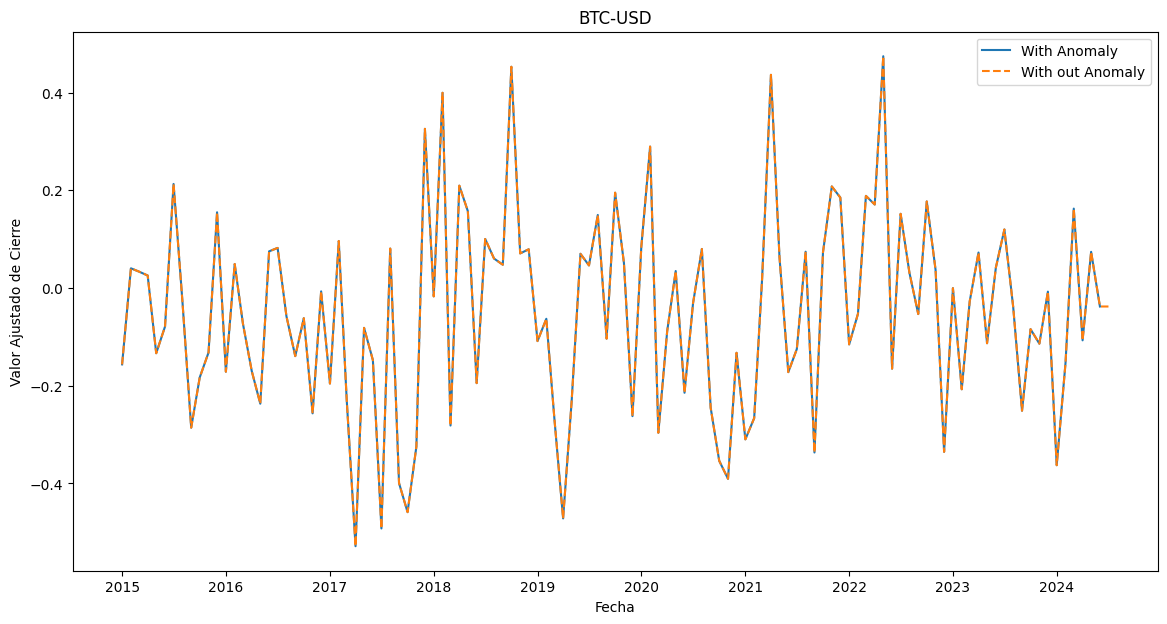

In [172]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = ts.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()

In [205]:
# Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función para calcular sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [204]:
# Inicialización de DataFrames para resultados
forecast_result_list = []
modelo_precision_forecast_list = []
timestamp = datetime.now().strftime('%Y-%m-%d')

# Función para optimizar ARIMA con Optuna
def optimize_ARIMA(trial, ts_ARIMA, training_duration, horizon, cutoffs):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)

    # Crear y entrenar el modelo ARIMA con los parámetros sugeridos por Optuna
    model = pm(order=(p, d, q))
    model.fit(ts_ARIMA)
    
    # Validación cruzada
    cv_results = cross_validate(model, 
                                initial=timedelta(days=training_duration), 
                                horizon=timedelta(days=horizon), 
                                parallel='threads', 
                                cutoffs=cutoffs)

    # Calcular métricas
    mape = mean_absolute_percentage_error(cv_results['y'], cv_results['yhat'])
    smape = symmetric_mean_absolute_percentage_error(cv_results['y'], cv_results['yhat'])

    # Retornar la métrica que se desea optimizar (sMAPE en este caso)
    return smape

In [202]:
proporcion_entrenamiento = 0.80
horizon_months = 3

def forecast_for_client(id, ts, horizon_months, proporcion_entrenamiento):
    try:
        # Ajuste de la serie temporal
        ts = ts.drop('unique_id', axis=1).sort_values(by='ds').reset_index(drop=True)
        ts['ds'] = pd.to_datetime(ts['ds'])

        # Horizon para el forecast
        horizon_days = horizon_months * 30.5

        # Splitting Training y Validación
        indice_entrenamiento = int(len(ts) * proporcion_entrenamiento)
        ts_entrenamiento = ts[:indice_entrenamiento]
        ts_validacion = ts[indice_entrenamiento:]
        ts_ARIMA = pd.concat([ts_entrenamiento, ts_validacion]).reset_index(drop=True)

        # Implementación del modelo ARIMA
        training_duration = len(ts_entrenamiento)
        cutoffs = pd.date_range(start=ts_validacion['ds'].min(), end=ts_validacion['ds'].max() - timedelta(days=horizon_days), freq='MS')

        # Optimización de parámetros ARIMA con Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_ARIMA(trial, ts_ARIMA, training_duration, horizon_days, cutoffs), n_trials=50)

        best_params = study.best_trial.params
        model = pm(order=(best_params['p'], best_params['d'], best_params['q']))
        model.fit(ts_ARIMA['y'])

        # Validación cruzada con pmdarima para evaluar el rendimiento
        df_cv_model = cross_validate(model, initial=training_duration, horizon=horizon_days, cutoffs=cutoffs, parallel='threads', disable_tqdm=True)

        # Calcular métricas de rendimiento
        mape_score = mean_absolute_percentage_error(df_cv_model['y'], df_cv_model['yhat'])
        smape_score = symmetric_mean_absolute_percentage_error(df_cv_model['y'], df_cv_model['yhat'])

        # Calcular precisión global
        last_cutoff = df_cv_model['cutoff'].max()
        df_cv_model_accuracy = df_cv_model[df_cv_model['cutoff'] == last_cutoff]
        total_real = df_cv_model_accuracy['y'].sum()
        total_forecast = df_cv_model_accuracy['yhat'].sum()

        if total_real == 0 and total_forecast == 0:
            smape_global = 0.0
        else:
            smape_global = 2 * np.mean(np.abs(total_real - total_forecast)) / (np.abs(total_real) + np.abs(total_forecast))

        min_smape = min(smape_score, smape_global)
        accuracy_general = round((1 - min_smape / 100), 2) * 100  

        # Pronóstico para el horizonte de predicción
        future = model.make_future_dataframe(periods=horizon_months, freq='MS', include_history=False)
        forecast = model.predict(future)

        forecast['ticker'] = id
        forecast['yhat'] = forecast['yhat'].round(2)
        forecast['ds'] = forecast['ds'].dt.strftime('%d-%m-%Y')

        resultado_accuracy = {
            'ticker': id,
            'accuracy': accuracy_general,
            'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        return resultado_accuracy, forecast[['ticker', 'ds', 'yhat']].to_dict('records')

    except Exception as e:
        print(f'Error procesando {id}. No existe suficiente información para realizar el forecasting: {e}')
        return None, None

In [206]:
# Ejemplo de uso con datos de serie temporal 'ts' (asegúrate de tener tus datos cargados y preparados en 'ts')
id = 'BTC-USD'  # Identificador del cliente o ticker en este caso
resultado_accuracy, forecast_result = forecast_for_client(id, ts, horizon_months, proporcion_entrenamiento)

# Imprimir resultados
print('Modelo y precisión de pronóstico:')
print(resultado_accuracy)
print('Pronósticos generados:')
print(forecast_result)

Error procesando BTC-USD. No existe suficiente información para realizar el forecasting: 'module' object is not callable
Modelo y precisión de pronóstico:
None
Pronósticos generados:
None
